In [1]:
%pip install captcha 
%pip install opencv-python
!apt update && apt install -y libsm6 libxext6
!pip install opencv-python-headless
!pip install opencv-contrib-python-headless
%pip install keras


import argparse
import json
import string
import os
import shutil
import uuid
from captcha.image import ImageCaptcha

import itertools

import os
import cv2
import numpy as np
from random import random, randint, choices

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


'apt' is not recognized as an internal or external command,
operable program or batch file.


Note: you may need to restart the kernel to use updated packages.


In [3]:
BATCH_SIZE = 128
NUM_OF_LETTERS = 4
EPOCHS = 50
IMG_ROW, IMG_COLS = 50, 150


# Non-configs
PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, 'train\\gen_captcha')

In [5]:
# checking channel
# img = cv2.imread(os.path.join(DATA_PATH, '9963_0_1680.png'),cv2.IMREAD_UNCHANGED)
# img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# cv2.imshow('img',img)
# cv2.waitKey(0)

-1

In [6]:
def load_data(path, test_split=0.1, width=IMG_COLS, height=IMG_ROW):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []

    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if '.png' in fl:
                flr = fl.split('_')[0]
                counter += 1
                label = np.zeros((NUM_OF_LETTERS, 10))
                for i in range(NUM_OF_LETTERS):
                    label[i, int(flr[i])] = 1

                img = cv2.imread(os.path.join(r, fl),cv2.IMREAD_UNCHANGED)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                img = cv2.resize(img, (int(width/2), int(height/2)), interpolation=cv2.INTER_AREA)
                img = np.reshape(img, (img.shape[0], img.shape[1], 1))

                if random() < test_split:
                    y_test.append(label)
                    x_test.append(img)
                else:
                    y_train.append(label)
                    x_train.append(img)

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [7]:
x_train, y_train, x_test, y_test = load_data(DATA_PATH)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

loading dataset...
dataset size: 14268 (train=12853, test=1415)


In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(12853, 25, 75, 1)
(12853, 4, 10)
(1415, 25, 75, 1)
(1415, 4, 10)


In [9]:
s_train = []
s_test = []
for i in range(NUM_OF_LETTERS):
    s_train.append(y_train[:, i, :])
    s_test.append(y_test[:, i, :])

In [10]:
save_dir = os.path.join(PATH, 'saved_models')
model_name = 'keras_cifar10_trained_jpj_model.h5'

In [11]:
input_layer = Input((int(IMG_ROW/2), int(IMG_COLS/2), 1))
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

out = [Dense(10, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
model = Model(inputs=input_layer, outputs=out)

In [12]:
# initiate Adam optimizer

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 75, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 25, 75, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 12, 37, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 37, 48)   38448       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [13]:
hist_train_loss_digit = {i:[] for i in range(NUM_OF_LETTERS)}
hist_test_loss_digit = {i:[] for i in range(NUM_OF_LETTERS)}

hist_train_acc_digit = {i:[] for i in range(NUM_OF_LETTERS)}
hist_test_acc_digit = {i:[] for i in range(NUM_OF_LETTERS)}

hist_train_loss = []
hist_test_loss = []

hist_train_acc = []
hist_test_acc = []

In [14]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []

In [15]:
history = model.fit(x_train, s_train, batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, s_test)
                   )

Epoch 1/50
101/101 [==============================] - 17s 35ms/step - loss: 1.5681 - digit0_loss: 0.3920 - digit1_loss: 0.3921 - digit2_loss: 0.3927 - digit3_loss: 0.3913 - digit0_accuracy: 0.1104 - digit1_accuracy: 0.0988 - digit2_accuracy: 0.1019 - digit3_accuracy: 0.1050 - val_loss: 1.3017 - val_digit0_loss: 0.3248 - val_digit1_loss: 0.3255 - val_digit2_loss: 0.3259 - val_digit3_loss: 0.3255 - val_digit0_accuracy: 0.1081 - val_digit1_accuracy: 0.1237 - val_digit2_accuracy: 0.1166 - val_digit3_accuracy: 0.0996
Epoch 2/50
101/101 [==============================] - 2s 25ms/step - loss: 1.3154 - digit0_loss: 0.3286 - digit1_loss: 0.3284 - digit2_loss: 0.3289 - digit3_loss: 0.3295 - digit0_accuracy: 0.1123 - digit1_accuracy: 0.1086 - digit2_accuracy: 0.1059 - digit3_accuracy: 0.0997 - val_loss: 1.2997 - val_digit0_loss: 0.3247 - val_digit1_loss: 0.3247 - val_digit2_loss: 0.3249 - val_digit3_loss: 0.3254 - val_digit0_accuracy: 0.1159 - val_digit1_accuracy: 0.1223 - val_digit2_accuracy: 0.

Epoch 17/50
101/101 [==============================] - 3s 25ms/step - loss: 0.0609 - digit0_loss: 0.0139 - digit1_loss: 0.0194 - digit2_loss: 0.0169 - digit3_loss: 0.0107 - digit0_accuracy: 0.9899 - digit1_accuracy: 0.9863 - digit2_accuracy: 0.9902 - digit3_accuracy: 0.9924 - val_loss: 0.0233 - val_digit0_loss: 0.0072 - val_digit1_loss: 0.0084 - val_digit2_loss: 0.0050 - val_digit3_loss: 0.0027 - val_digit0_accuracy: 0.9943 - val_digit1_accuracy: 0.9936 - val_digit2_accuracy: 0.9979 - val_digit3_accuracy: 0.9979
Epoch 18/50
101/101 [==============================] - 2s 24ms/step - loss: 0.0523 - digit0_loss: 0.0117 - digit1_loss: 0.0159 - digit2_loss: 0.0152 - digit3_loss: 0.0095 - digit0_accuracy: 0.9922 - digit1_accuracy: 0.9888 - digit2_accuracy: 0.9929 - digit3_accuracy: 0.9961 - val_loss: 0.0203 - val_digit0_loss: 0.0052 - val_digit1_loss: 0.0078 - val_digit2_loss: 0.0048 - val_digit3_loss: 0.0025 - val_digit0_accuracy: 0.9965 - val_digit1_accuracy: 0.9922 - val_digit2_accuracy: 0

Epoch 33/50
101/101 [==============================] - 2s 24ms/step - loss: 0.0218 - digit0_loss: 0.0045 - digit1_loss: 0.0070 - digit2_loss: 0.0066 - digit3_loss: 0.0037 - digit0_accuracy: 0.9979 - digit1_accuracy: 0.9975 - digit2_accuracy: 0.9971 - digit3_accuracy: 0.9993 - val_loss: 0.0083 - val_digit0_loss: 0.0021 - val_digit1_loss: 0.0028 - val_digit2_loss: 0.0025 - val_digit3_loss: 9.2161e-04 - val_digit0_accuracy: 0.9986 - val_digit1_accuracy: 0.9979 - val_digit2_accuracy: 0.9993 - val_digit3_accuracy: 0.9993
Epoch 34/50
101/101 [==============================] - 2s 24ms/step - loss: 0.0200 - digit0_loss: 0.0044 - digit1_loss: 0.0064 - digit2_loss: 0.0058 - digit3_loss: 0.0033 - digit0_accuracy: 0.9975 - digit1_accuracy: 0.9972 - digit2_accuracy: 0.9978 - digit3_accuracy: 0.9986 - val_loss: 0.0086 - val_digit0_loss: 0.0022 - val_digit1_loss: 0.0036 - val_digit2_loss: 0.0017 - val_digit3_loss: 9.7621e-04 - val_digit0_accuracy: 0.9986 - val_digit1_accuracy: 0.9979 - val_digit2_acc

Epoch 49/50
101/101 [==============================] - 3s 25ms/step - loss: 0.0133 - digit0_loss: 0.0027 - digit1_loss: 0.0035 - digit2_loss: 0.0043 - digit3_loss: 0.0028 - digit0_accuracy: 0.9992 - digit1_accuracy: 0.9985 - digit2_accuracy: 0.9994 - digit3_accuracy: 0.9983 - val_loss: 0.0069 - val_digit0_loss: 0.0017 - val_digit1_loss: 0.0030 - val_digit2_loss: 0.0012 - val_digit3_loss: 9.3010e-04 - val_digit0_accuracy: 0.9986 - val_digit1_accuracy: 0.9972 - val_digit2_accuracy: 1.0000 - val_digit3_accuracy: 1.0000
Epoch 50/50
101/101 [==============================] - 2s 24ms/step - loss: 0.0133 - digit0_loss: 0.0028 - digit1_loss: 0.0041 - digit2_loss: 0.0042 - digit3_loss: 0.0022 - digit0_accuracy: 0.9992 - digit1_accuracy: 0.9985 - digit2_accuracy: 0.9984 - digit3_accuracy: 0.9994 - val_loss: 0.0062 - val_digit0_loss: 0.0020 - val_digit1_loss: 0.0025 - val_digit2_loss: 0.0012 - val_digit3_loss: 5.2837e-04 - val_digit0_accuracy: 0.9979 - val_digit1_accuracy: 0.9986 - val_digit2_acc

In [16]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []


def plot_diagram(digit_acc_now, val_digit_acc_now, loss_now, val_loss_now):
    global digit_acc, val_digit_acc, loss, val_loss
    
    for i in range(NUM_OF_LETTERS):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)
    
    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        # plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        # plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()



    # Plot training & validation loss values
    plt.plot(val_loss, label='Train')
    plt.plot(loss, label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

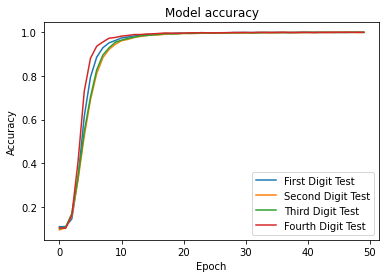

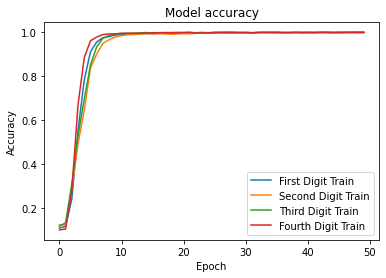

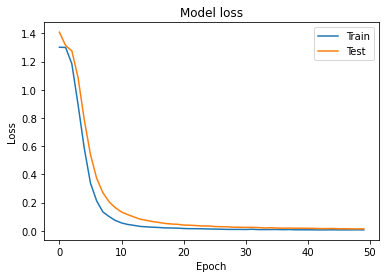

In [17]:
plot_diagram(
    
    [history.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    [history.history['val_digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    history.history['loss'],
    history.history['val_loss'],
)

In [18]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\Qwerty\Downloads\captcha_solver\saved_models\keras_cifar10_trained_jpj_model.h5 


In [19]:
# Score trained model.
scores = model.evaluate(x_train, s_train, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:NUM_OF_LETTERS]))
acc = 1.
for i in range(NUM_OF_LETTERS):
    acc *= scores[NUM_OF_LETTERS+1+i]
print('Train accuracy: %.2f' % (acc * 100.))

402/402 [==============================] - 3s 8ms/step - loss: 1.8969e-04 - digit0_loss: 4.7383e-05 - digit1_loss: 5.7723e-05 - digit2_loss: 5.5999e-05 - digit3_loss: 2.8581e-05 - digit0_accuracy: 1.0000 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 1.0000
Train loss:     0.000088
Train accuracy: 100.00


In [20]:
scores = model.evaluate(x_test, s_test, verbose=1)
print('Test loss:     %f' % np.mean(scores[0:NUM_OF_LETTERS]))
acc = 1.
for i in range(NUM_OF_LETTERS):
    acc *= scores[NUM_OF_LETTERS+1+i]
print('Test accuracy: %.2f' % (acc * 100.))

45/45 [==============================] - 0s 8ms/step - loss: 0.0062 - digit0_loss: 0.0020 - digit1_loss: 0.0025 - digit2_loss: 0.0012 - digit3_loss: 5.2844e-04 - digit0_accuracy: 0.9979 - digit1_accuracy: 0.9986 - digit2_accuracy: 1.0000 - digit3_accuracy: 1.0000  
Test loss:     0.002959
Test accuracy: 99.65
